In [82]:
%mkdir -p prodata/test3

In [83]:
import warnings

warnings.filterwarnings('ignore')

In [84]:
from scipy.stats import ttest_ind

from tqdm.auto import tqdm
import numpy as np

import pandas as pd

import json

from statsmodels.stats.multitest import multipletests

In [85]:
counts = pd.read_table('data/ibd/data_counts.tsv', index_col=0)
relab = pd.read_table('data/ibd/data_tss.tsv', index_col=0)
meta = pd.read_table('data/ibd/meta.tsv', index_col=0)

# classified, prevalence 50%
counts = counts[[c for c in list(counts) if 'unclass' not in c]]
c = counts.replace(0, np.nan).notna().mean()
usecols = c[c > 0.5].index
print(len(usecols), counts.shape[1])

counts = counts[usecols]
relab = relab[usecols]

counts.head(2)

750 5864


,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Actinobacteria|c__Actinobacteria,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinobacteria_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinobacteria_unclassified|f__Actinobacteria_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinobacteria_unclassified|f__Actinobacteria_unclassified|g__Actinobacteria_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinobacteria_unclassified|f__Actinobacteria_unclassified|g__Actinobacteria_unclassified|s__Actinobacteria_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinobacteria_unclassified|f__Actinobacteria_unclassified|g__Actinobacteria_unclassified|s__Actinobacteria_unclassified|a__Actinobacteria_ASV76,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,...,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacteriaceae_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacteriaceae_unclassified|s__Enterobacteriaceae_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacteriaceae_unclassified|s__Enterobacteriaceae_unclassified|a__Enterobacteriaceae_ASV51,k__Bacteria|p__Verrucomicrobia,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Akkermansia|s__Akkermansia_muciniphila|a__Akkermansia_ASV1397
S21_001K,8371,7095,273,273,273,273,199,2,2,1,...,549,549,549,7052,7043,7043,7043,7037,8,8
S21_001P,2434,1158,41,41,41,41,41,0,0,0,...,69,69,69,0,0,0,0,0,0,0


In [86]:
# unrarified-counts for ancomb
counts.sum(axis=1)

S21_001K     968100
S21_001P    1270665
S21_002K    1234588
S21_002P    1029407
S21_003K     997449
             ...   
S21_148K    1009934
S21_148P     669061
S21_149P     867671
S21_150K    1171153
S21_150P     843814
Length: 273, dtype: int64

In [87]:
# map column names to simpler one for R
map_columns = dict(zip(list(counts), [f"t{k}" for k in range(len(usecols))]))

In [88]:
counts.rename(columns=map_columns).to_csv('prodata/test3/ancomb_counts.tsv', sep='\t')
meta[['Group', 'Group']].to_csv('prodata/test3/ancomb_meta.tsv', sep='\t')

In [14]:
ancomb_res = pd.read_csv('prodata/test3/ancomb_results_bh.csv', index_col=0)
ancomb_res['taxon'] = ancomb_res['taxon'].map({
    v: k
    for k, v in map_columns.items()
})
ancomb_res['org'] = ancomb_res['taxon'].apply(lambda x: x.split('|')[-1][0])
ancomb_res = ancomb_res[[
    'taxon', 'org', 'p_GroupIBD', 'passed_ss_GroupIBD', 'q_GroupIBD'
]]

ancomb_res[(ancomb_res.q_GroupIBD < 0.05)
           & (ancomb_res.passed_ss_GroupIBD)].to_excel(
               'prodata/ancomb_ibd_results_BH.xlsx', index=False)

orgs = ['p', 'c', 'o', 'f', 'g', 's', 'a']
ancomb_res[(ancomb_res.q_GroupIBD < 0.05) & (ancomb_res.passed_ss_GroupIBD)].org.value_counts().loc[orgs]

org
p     2
c     4
o    11
f    18
g    31
s    17
a    13
Name: count, dtype: int64

In [15]:
ancomb_res = pd.read_csv('prodata/test3/ancomb_results_holm.csv', index_col=0)
ancomb_res['taxon'] = ancomb_res['taxon'].map({
    v: k
    for k, v in map_columns.items()
})
ancomb_res['org'] = ancomb_res['taxon'].apply(lambda x: x.split('|')[-1][0])
ancomb_res = ancomb_res[[
    'taxon', 'org', 'p_GroupIBD', 'passed_ss_GroupIBD', 'q_GroupIBD'
]]

ancomb_res[(ancomb_res.q_GroupIBD < 0.05)
           & (ancomb_res.passed_ss_GroupIBD)].to_excel(
               'prodata/ancomb_ibd_results_HOLM.xlsx', index=False)

orgs = ['p', 'c', 'o', 'f', 'g', 's', 'a']
ancomb_res[(ancomb_res.q_GroupIBD < 0.05) & (ancomb_res.passed_ss_GroupIBD)].org.value_counts().loc[orgs]

org
p     2
c     3
o     6
f    10
g    15
s     7
a     4
Name: count, dtype: int64

In [16]:
ancomb_res = pd.read_csv('prodata/test3/ancomb_results_na.csv', index_col=0)
ancomb_res['taxon'] = ancomb_res['taxon'].map({
    v: k
    for k, v in map_columns.items()
})
ancomb_res['org'] = ancomb_res['taxon'].apply(lambda x: x.split('|')[-1][0])
ancomb_res = ancomb_res[[
    'taxon', 'org', 'p_GroupIBD', 'passed_ss_GroupIBD', 'q_GroupIBD'
]]

ancomb_res[(ancomb_res.q_GroupIBD < 0.05)
           & (ancomb_res.passed_ss_GroupIBD)].to_excel(
               'prodata/ancomb_ibd_results_NA.xlsx', index=False)

orgs = ['p', 'c', 'o', 'f', 'g', 's', 'a']
ancomb_res[(ancomb_res.q_GroupIBD < 0.05) & (ancomb_res.passed_ss_GroupIBD)].org.value_counts().loc[orgs]

org
p     3
c     5
o    11
f    22
g    34
s    19
a    15
Name: count, dtype: int64

In [89]:
from scipy.stats import norm

def hodges_lehmann(vals, alpha=0.01):

    A, B = vals

    n = len(A)
    m = len(B)

    M = list(sorted([a - b for a in A for b in B]))

    # https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Normal_approximation_and_tie_correction
    # half of sample size +- z score for CI * pooled std of sample size
    # expected U H0, sd U H0
    ZN = norm.ppf(1 - alpha / 2)  # one of tails
    EUH0 = n * m / 2
    SUH0 = (n * m * (n + m + 1) / 12)**0.5

    L = EUH0 - ZN * SUH0
    U = EUH0 + ZN * SUH0

    # for python
    lower = int(round(L) - 1)
    upper = int(round(U) - 1)

    # for boundaries
    lower = max(lower, 0)
    upper = min(upper, len(M) - 1)

    lower = M[lower]
    upper = M[upper]

    return (lower, upper)

In [90]:
res = {}

for col in tqdm(list(relab)):
    vals = [
        relab[meta.Group == 'HR'][col].values,
        relab[meta.Group == 'IBD'][col].values
    ]
    
    ci = CI = hodges_lehmann(vals, 0.05)
    strict05 = np.sign(ci[0]) == np.sign(ci[1]) and (ci[0] != 0
                                                     and ci[1] != 0)
    
    ci = CI = hodges_lehmann(vals, 0.01)
    strict01 = np.sign(ci[0]) == np.sign(ci[1]) and (ci[0] != 0
                                                     and ci[1] != 0)
    
    ci = CI = hodges_lehmann(vals, 0.001)
    strict001 = np.sign(ci[0]) == np.sign(ci[1]) and (ci[0] != 0
                                                     and ci[1] != 0)
    
    
    res[col] = {'org': col.split('|')[-1][0], 'HLE-CI_0.05': strict05, 'HLE-CI_0.01': strict01, 'HLE-CI_0.001': strict001}

res = pd.DataFrame(res).T

100%|███████████████████████████████████████████████████████████████████████| 750/750 [00:17<00:00, 43.74it/s]


In [91]:
res[res['HLE-CI_0.05']].to_excel('prodata/hle_ibd_results005.xlsx')
res[res['HLE-CI_0.01']].to_excel('prodata/hle_ibd_results001.xlsx')
res[res['HLE-CI_0.001']].to_excel('prodata/hle_ibd_results0001.xlsx')

In [25]:
res1 = pd.read_excel('prodata/ancomb_ibd_results_NA.xlsx', index_col=0)
res2 = pd.read_excel('prodata/ancomb_ibd_results_HOLM.xlsx', index_col=0)
res3 = pd.read_excel('prodata/ancomb_ibd_results_BH.xlsx', index_col=0)

res4 = pd.read_excel('prodata/hle_ibd_results005.xlsx', index_col=0)
res5 = pd.read_excel('prodata/hle_ibd_results001.xlsx', index_col=0)
res6 = pd.read_excel('prodata/hle_ibd_results0001.xlsx', index_col=0)

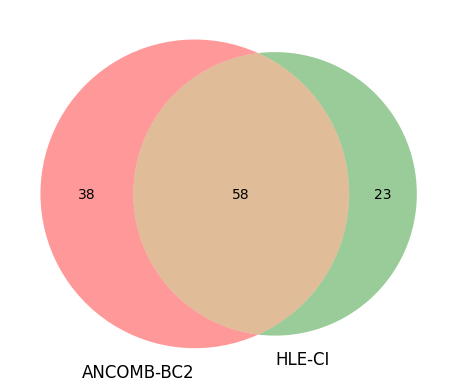

In [67]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

set1 = set(res3.index)
set2 = set(res6.index)

venn2([set1, set2], ('ANCOMB-BC2', 'HLE-CI'))

plt.show()

In [79]:
[m for m in res3[res3.org=='g'].index if m not in res5.index]

['k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Rothia',
 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Merdibacter',
 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus',
 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Limosilactobacillus',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__-Eubacterium-_coprostanoligenes_group|g__-Eubacterium-_coprostanoligenes_group_uncultured_organism',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Peptostreptococcales-Tissierellales|f__Anaerovoracaceae|g__-Eubacterium-_nodatum_group']

In [80]:
[m for m in res5[res5.org=='g'].index if m not in res3.index]

['k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Marinifilaceae|g__Butyricimonas',
 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Defluviitaleaceae|g__Defluviitaleaceae_UCG-011',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__-Ruminococcus-_torques_group',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Dorea',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-003',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Marvinbryantia',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Moryella',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Butyricicoc